<a href="https://colab.research.google.com/github/hogan-tech/AAI-595-Final/blob/main/ML_Project_Time_Series(V2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [ ]:
!pip install kaggle

In [ ]:
!pip install --upgrade holidays

In [ ]:
#Importing all the required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import holidays
import os
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#Import Hourly Energy Consumption Dataset

The hourly energy consumption datasets consist of energy (megawatt units) of different power companies in the US.

In [ ]:
#Loading the dataset
import kagglehub

path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

100%|██████████| 11.4M/11.4M [00:00<00:00, 52.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


# Import holiday dataset
We want to use external US holiday dataset to see if we can find a pattern of energy consumption around holiday days

In [ ]:
path_holiday = kagglehub.dataset_download("donnetew/us-holiday-dates-2004-2021")

100%|██████████| 2.45k/2.45k [00:00<00:00, 4.50MB/s]

Extracting files...


In [ ]:
print("Path to holiday dataset:", path_holiday)


Path to holiday dataset: /root/.cache/kagglehub/datasets/donnetew/us-holiday-dates-2004-2021/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/robikscube/hourly-energy-consumption/versions/3


AEP_hourly.csv	   DEOK_hourly.csv  EKPC_hourly.csv	NI_hourly.csv	    PJM_Load_hourly.csv
COMED_hourly.csv   DOM_hourly.csv   est_hourly.paruqet	PJME_hourly.csv     PJMW_hourly.csv
DAYTON_hourly.csv  DUQ_hourly.csv   FE_hourly.csv	pjm_hourly_est.csv


# 1. Data Exploration and Analysis


## 1.1 Merging the energy consumption datasets
By Yian

In [ ]:
aep = pd.read_csv(os.path.join(path, "AEP_hourly.csv"))
comed = pd.read_csv(os.path.join(path, "COMED_hourly.csv"))
dayton = pd.read_csv(os.path.join(path, "DAYTON_hourly.csv"))
deok = pd.read_csv(os.path.join(path, "DEOK_hourly.csv"))
dom = pd.read_csv(os.path.join(path, "DOM_hourly.csv"))
duq = pd.read_csv(os.path.join(path, "DUQ_hourly.csv"))
ekpc = pd.read_csv(os.path.join(path, "EKPC_hourly.csv"))
fe = pd.read_csv(os.path.join(path, "FE_hourly.csv"))
ni = pd.read_csv(os.path.join(path, "NI_hourly.csv"))
pjme = pd.read_csv(os.path.join(path, "PJME_hourly.csv"))
pjm = pd.read_csv(os.path.join(path, "pjm_hourly_est.csv")) # diff format
pjm_load = pd.read_csv(os.path.join(path, "PJM_Load_hourly.csv"))
pjmw = pd.read_csv(os.path.join(path, "PJMW_hourly.csv"))

In [ ]:
aep["company"] = "AEP_MW"
comed["company"] = "COMED_MW"
dayton["company"] = "DAYTON_MW"
deok["company"] = "DEOK_MW"
dom["company"] = "DOM_MW"
duq["company"] = "DUQ_MW"
ekpc["company"] = "EKPC_MW"
fe["company"] = "FE_MW"
ni["company"] = "NI_MW"
pjme["company"] = "PJME_MW"
pjmw["company"] = "PJMW_MW"
pjm_load["company"] = "PJM_Load_MW"

In [ ]:
aep = aep.rename(columns={"AEP_MW": "MW"})
comed = comed.rename(columns={"COMED_MW": "MW"})
dayton = dayton.rename(columns={"DAYTON_MW": "MW"})
deok = deok.rename(columns={"DEOK_MW": "MW"})
dom = dom.rename(columns={"DOM_MW": "MW"})
duq = duq.rename(columns={"DUQ_MW": "MW"})
ekpc = ekpc.rename(columns={"EKPC_MW": "MW"})
fe = fe.rename(columns={"FE_MW": "MW"})
ni = ni.rename(columns={"NI_MW": "MW"})
pjme = pjme.rename(columns={"PJME_MW": "MW"})
pjmw = pjmw.rename(columns={"PJMW_MW": "MW"})
pjm_load = pjm_load.rename(columns={"PJM_Load_MW": "MW"})

In [ ]:
df_combined = pd.concat([aep, comed, dayton, deok, dom, duq, ekpc, fe, ni, pjme, pjmw, pjm_load], ignore_index=True)
df_combined.head()

,Datetime,MW,company
0,2004-12-31 01:00:00,13478.0,AEP_MW
1,2004-12-31 02:00:00,12865.0,AEP_MW
2,2004-12-31 03:00:00,12577.0,AEP_MW
3,2004-12-31 04:00:00,12517.0,AEP_MW
4,2004-12-31 05:00:00,12670.0,AEP_MW


In [ ]:
df_combined.shape

(1090167, 3)

In [ ]:
df_c = df_combined.copy()

In [ ]:
df_c .columns

Index(['Datetime', 'MW', 'company'], dtype='object')

## 1.2 Check dataset type and statistical breakdown
By Yian

In [ ]:
df_c .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090167 entries, 0 to 1090166
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Datetime  1090167 non-null  object 
 1   MW        1090167 non-null  float64
 2   company   1090167 non-null  object 
dtypes: float64(1), object(2)
memory usage: 25.0+ MB


In [ ]:
df_c .describe()

,MW
count,1.090167e+06
mean,1.120959e+04
std,1.053440e+04
min,0.000000e+00
25%,2.455000e+03
50%,8.217000e+03
75%,1.466500e+04
max,6.200900e+04


### Check if there are null values

In [ ]:
# no null values in dataset
df_c .isna().sum()

,0
Datetime,0
MW,0
company,0


## 1.4 Separate categorical from numerical attributes for data visualization
By Yian

In [ ]:
numerical_attributes = df_c .select_dtypes( include=['float64'] )
numerical_attributes.head()

,MW
0,13478.0
1,12865.0
2,12577.0
3,12517.0
4,12670.0


In [ ]:
categorical_attributes = df_c ["company"]
categorical_attributes.head()

,company
0,AEP_MW
1,AEP_MW
2,AEP_MW
3,AEP_MW
4,AEP_MW


## 1.5 Data Analysis
By Yian
<br>
Get the central tendency mean and median of the energy consumption dataset to check the typical data point. Check standard deviation, skewness and kurtosis of the dataset

In [ ]:
num_att_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
num_att_median = pd.DataFrame(numerical_attributes.apply(np.median)).T
d1 = pd.DataFrame(numerical_attributes.apply(np.std)).T # standard deviation
d2 = pd.DataFrame(numerical_attributes.apply(min)).T
d3 = pd.DataFrame(numerical_attributes.apply(max)).T
d4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T # range
d5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T # skewness
d6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T # kurtosis


In [ ]:
stats_df = pd.concat([d1,d2,d3,d4,d5,d6,num_att_mean,num_att_median]).T

In [ ]:
# rename columns
stats_df.columns = ["std", "min", "max", "range", "skew", "kurtosis", "mean", "median"]

In [ ]:
stats_df

,std,min,max,range,skew,kurtosis,mean,median
MW,10534.394704,0.0,62009.0,62009.0,1.356423,1.198281,11209.58865,8217.0


## 1.6 Check the distribution of the data
By Yian

<Axes: xlabel='MW', ylabel='Count'>

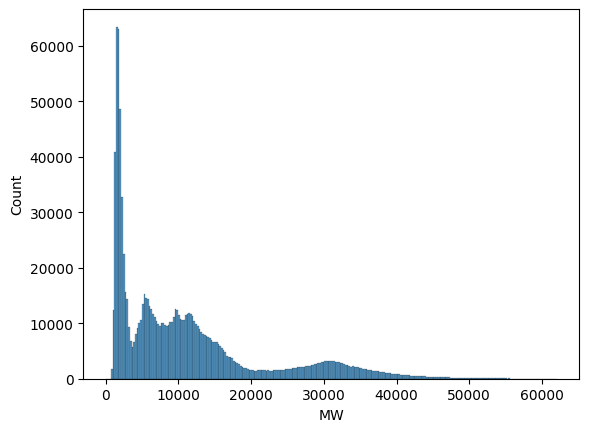

In [ ]:
import seaborn as sns
sns.histplot( df_c['MW'] )


## 1.7 Data Analysis
By Yian
<br>
<br>
From the histogram we can see the distribution of the data, which shows a right-skewed distribution. The high standard deviation (10534.39) also indicates a large spread and variability in the energy consumption values.  Most of the data points are concentrated in the lower range, with a long tail extending to the right. The right tail indicates some extreme outliers, where energy consumption is high in some cases on certain dates, pulling the distribution to the right. We shall analysis what are the causes of these outliers and apply normalization technique to help our predictive modeling. Beause our data has a high range and standard deviation, it is better to normalize the data first so our model can converge more efficiently when learning the patterns of the training data. The mean of the dataset is 11209.25, which is higher than the median (8217.00), which is also typical in right-skewed distribution in this case.

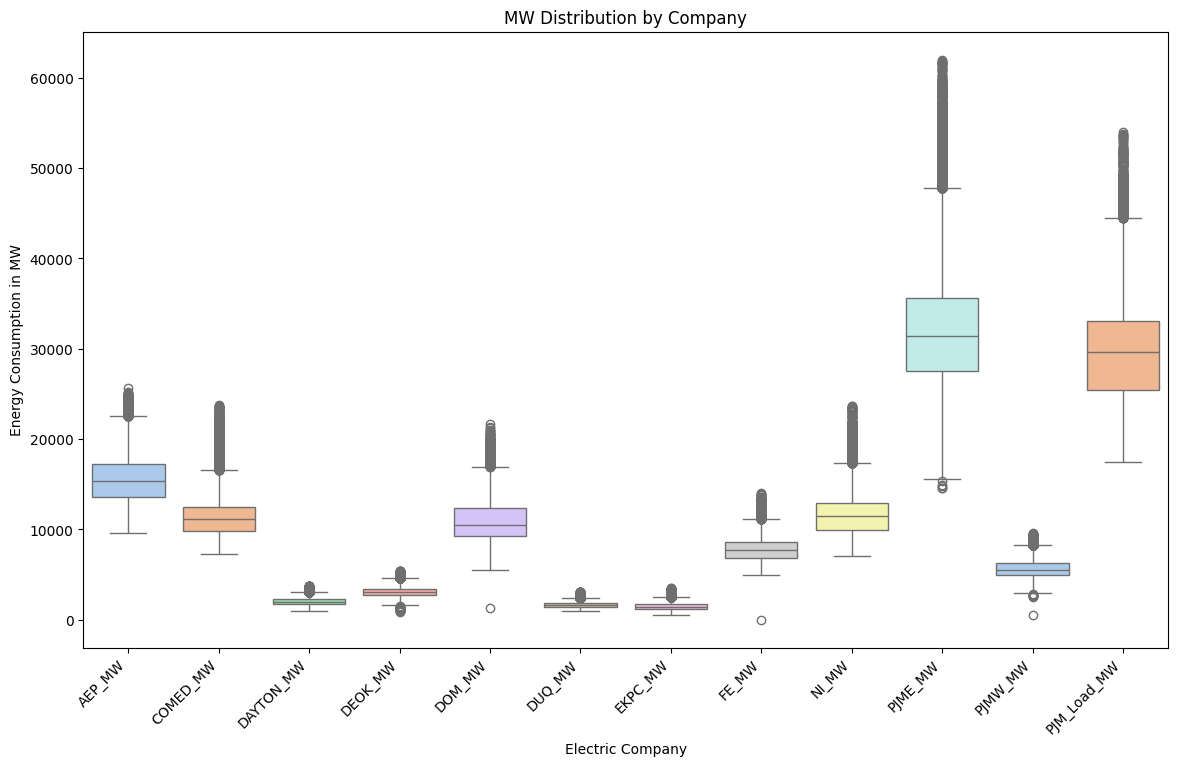

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot( x="company", y="MW", data=df_c, palette="pastel", hue="company")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.title("MW Distribution by Company")
plt.xlabel("Electric Company")
plt.ylabel("Energy Consumption in MW")
plt.show()

## 1.8 Check how the data varies on daily, weekly and monthly basis
by pranay


In [ ]:
df1 = pjme.copy()
df1 = df1.set_index('Datetime')
df1.index = pd.to_datetime(df1.index)

In [ ]:
import seaborn as sns
df1['hour'] = df1.index.hour
df1['dayofweek'] = df1.index.dayofweek
df1['quarter'] = df1.index.quarter
df1['month'] = df1.index.month
df1['year'] = df1.index.year
df1['dayofyear'] = df1.index.dayofyear
df1['dayofmonth'] = df1.index.day
df1['weekofyear'] = df1.index.isocalendar().week
print(df1.head())
import pandas as pd

def create_features(df):
    # Ensure that 'Datetime' is in datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Set 'Datetime' as the index
    df.set_index('Datetime', inplace=True)

    # Add time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week  # ISO week number

    # Optionally, reset index if you want 'Datetime' back as a column
    df.reset_index(inplace=True)

    return df




                          MW  company  hour  dayofweek  quarter  month  year  \
Datetime                                                                       
2002-12-31 01:00:00  26498.0  PJME_MW     1          1        4     12  2002   
2002-12-31 02:00:00  25147.0  PJME_MW     2          1        4     12  2002   
2002-12-31 03:00:00  24574.0  PJME_MW     3          1        4     12  2002   
2002-12-31 04:00:00  24393.0  PJME_MW     4          1        4     12  2002   
2002-12-31 05:00:00  24860.0  PJME_MW     5          1        4     12  2002   

                     dayofyear  dayofmonth  weekofyear  
Datetime                                                
2002-12-31 01:00:00        365          31           1  
2002-12-31 02:00:00        365          31           1  
2002-12-31 03:00:00        365          31           1  
2002-12-31 04:00:00        365          31           1  
2002-12-31 05:00:00        365          31           1  


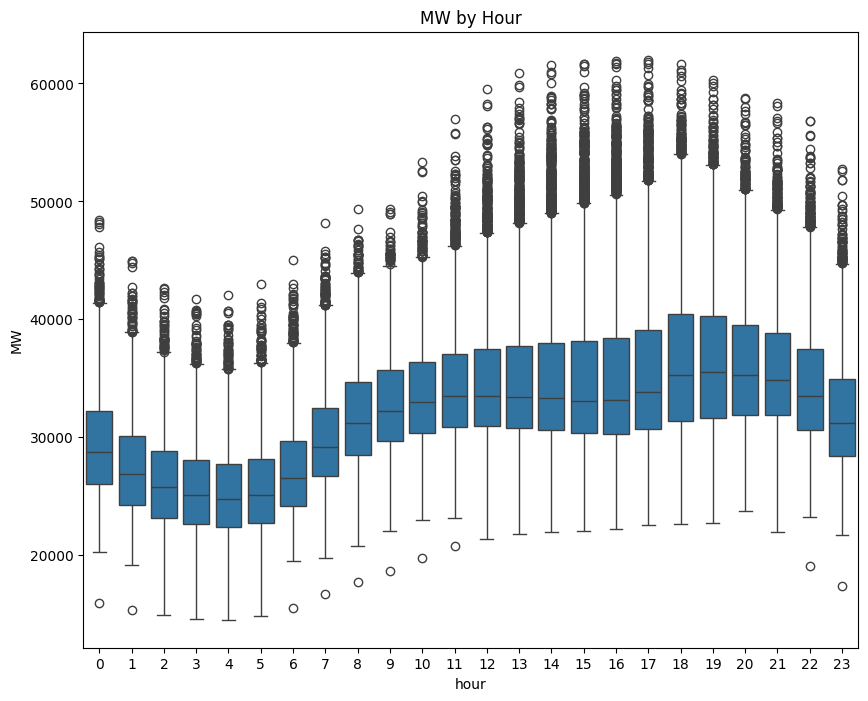

In [ ]:
#Hourly analysis
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df1, x='hour', y='MW')
ax.set_title('MW by Hour')
plt.show()

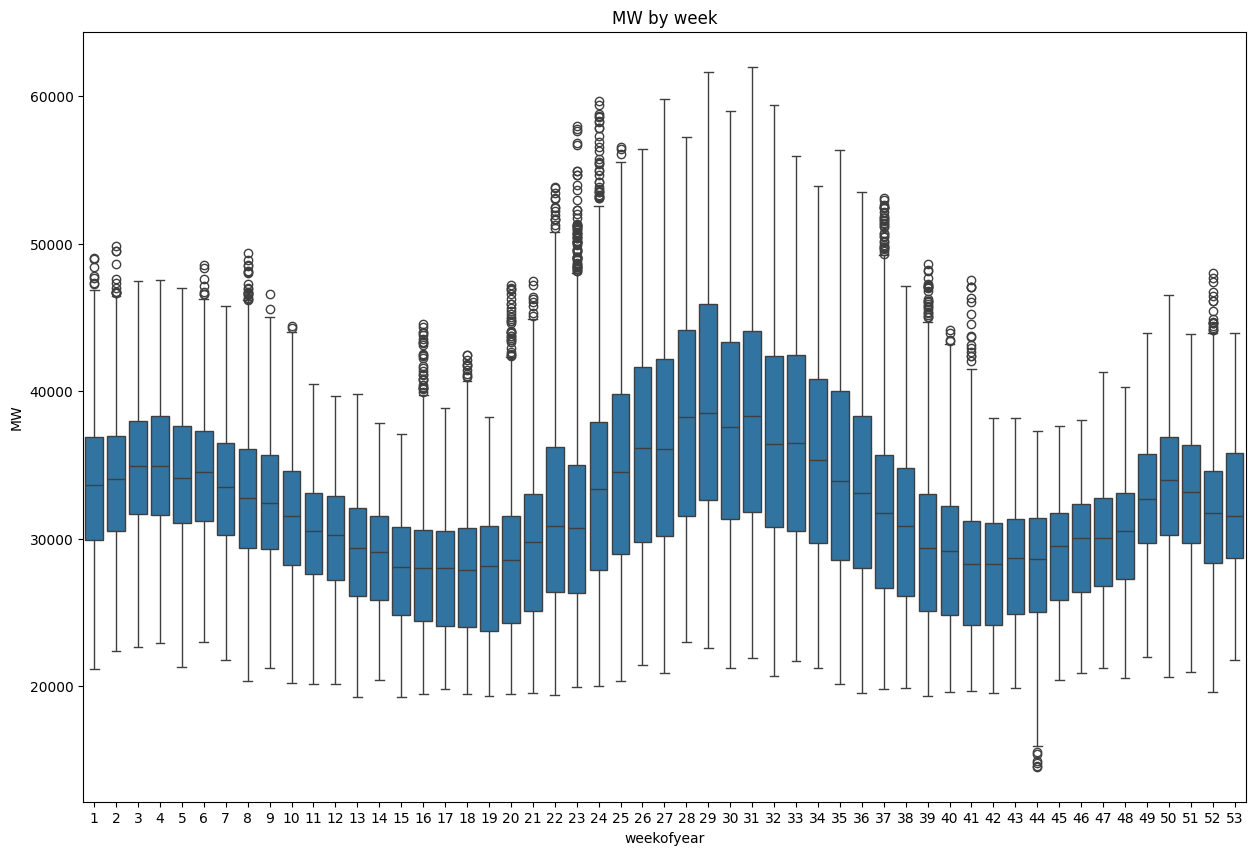

In [ ]:
#weekly analysis
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df1, x='weekofyear', y='MW')
ax.set_title('MW by week')
plt.show()

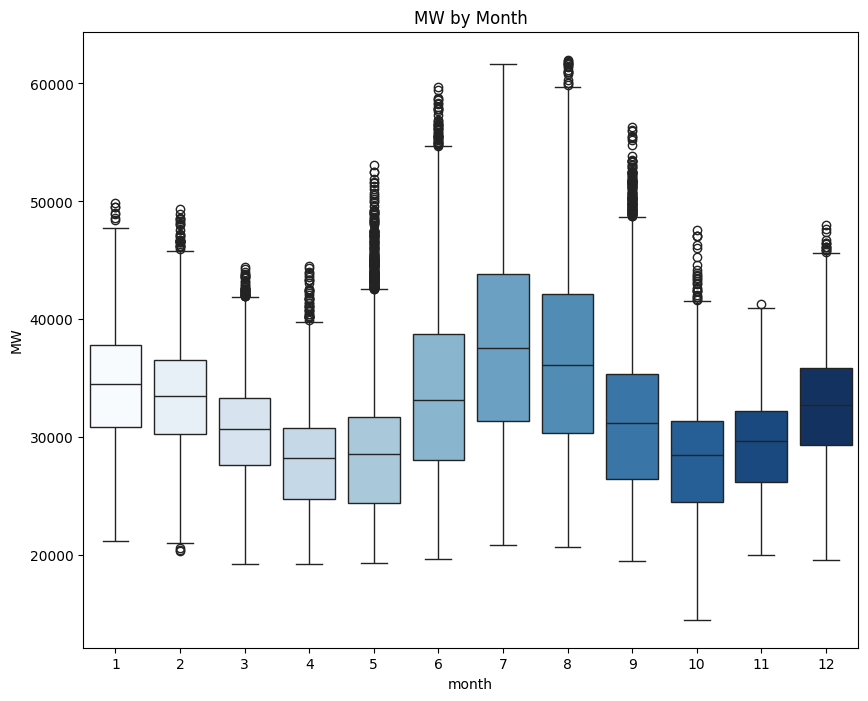

In [ ]:
#Montly analysis
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df1, x='month', y='MW', palette='Blues',legend=False,hue='month')
ax.set_title('MW by Month')
plt.show()

### 1.8.1 Analysis report
by pranay

When we check these boxplots , we can come to a conclusion that
- hourly report says that during the mornings the usage goes up and stays up until night when it goes low so we can conclude that the day time power usage is more than the night time usage.
-Monthy report says that during the mid months june,july and august, the power consumption is high while april and may has low power consumption.
- We can take some insights and continue our data analysis further .

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


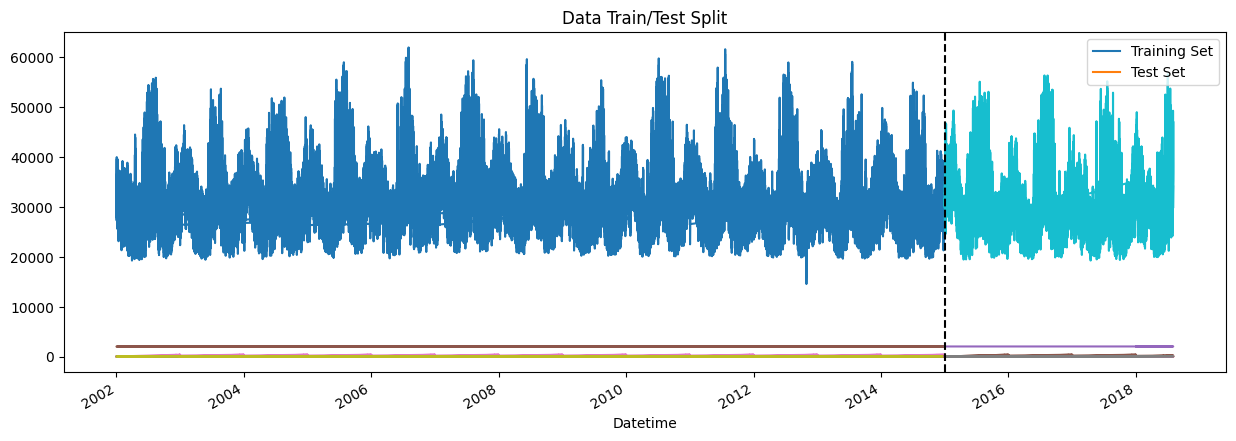

In [ ]:

train = df1.loc[df1.index < '01-01-2015']
test = df1.loc[df1.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
#train = create_features(train)
#test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:57:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

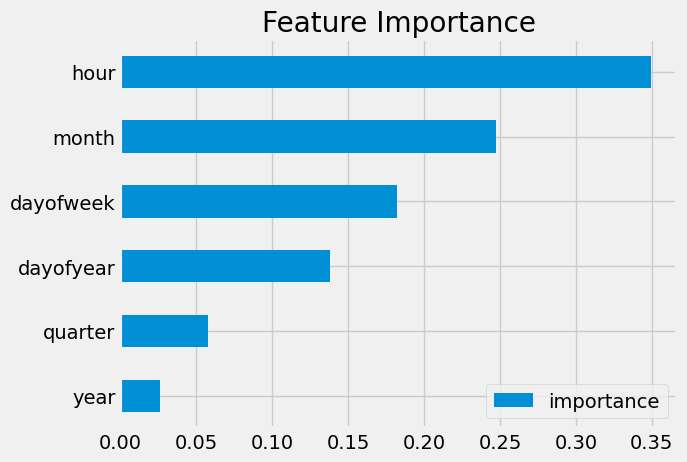

In [ ]:
 fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## 1.9 Check if US holidays have any correlation or pattern on energy consumption
By Yian
<br>

Hypothesis 1: There is more energy consumption on holiday days

In [ ]:
#@title Check Holiday Dates and add is_holiday boolean column
df_combined["Datetime"] = pd.to_datetime(df_combined["Datetime"])
us_holidays = holidays.US()
df_combined["is_holiday"] = df_combined["Datetime"].apply(lambda x: True if x in us_holidays else False)

In [ ]:
correlation = df_combined["is_holiday"].corr(df_combined["MW"])
print(f"Correlation between holidays and energy consumption: {correlation:.2f}")

Correlation between holidays and energy consumption: -0.01


In [ ]:
holiday_consumption = df_combined.groupby("is_holiday")["MW"].mean()
print(holiday_consumption)


is_holiday
False    11220.633130
True     10856.811053
Name: MW, dtype: float64


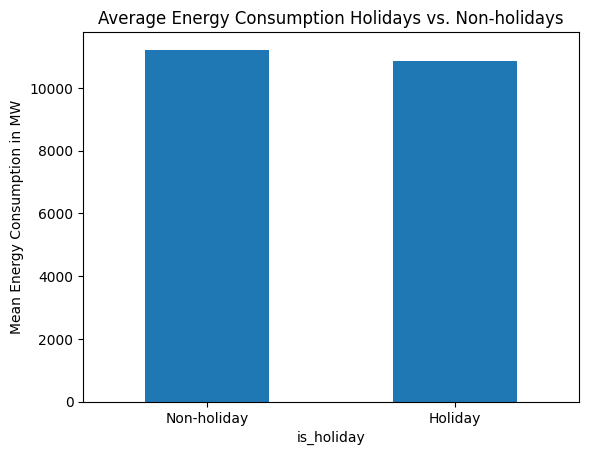

In [ ]:
import matplotlib.pyplot as plt

holiday_consumption.plot(kind="bar", title="Average Energy Consumption Holidays vs. Non-holidays")
plt.ylabel("Mean Energy Consumption in MW")
plt.xticks([0, 1], ["Non-holiday", "Holiday"], rotation=0)
plt.show()


### Findings on correlation between average use of energy on holiday days and non-holiday days
The correation is -0.01, and from the bar chart we find the average consumption of energy is actually less on holiday days. The low negative correlation shows that there's no significant linear correlation between holidays and energy consumption.

## 1.10 Check specific holiday days (Thanksgiving and Christmas) and one week leading up to these holidays
By Yian
<br>

Check if there's a correlationship between energy consumption one week leading up to the major holidays like Christmas and Thanksgiving, and on the day of these holidays

In [ ]:
def is_christmas(date):
    return date.month == 12 and date.day == 25

def is_thanksgiving(date):
    return date in us_holidays and us_holidays.get(date) == "Thanksgiving"

df_combined["is_christmas"] = df_combined["Datetime"].dt.date.apply(is_christmas)
df_combined["is_thanksgiving"] = df_combined["Datetime"].dt.date.apply(is_thanksgiving)

df_combined["is_week_before_christmas"] = df_combined["Datetime"].dt.date.apply(
    lambda x: (pd.Timestamp(year=x.year, month=12, day=18) <= pd.Timestamp(x) < pd.Timestamp(year=x.year, month=12, day=25))
)

df_combined["is_week_before_thanksgiving"] = df_combined["Datetime"].dt.date.apply(
    lambda x: (pd.Timestamp(x) - pd.DateOffset(weeks=1)).date() in us_holidays and us_holidays.get((pd.Timestamp(x) - pd.DateOffset(weeks=1)).date()) == "Thanksgiving"
)


In [ ]:
df_combined.head()

,Datetime,MW,company,is_holiday,is_christmas,is_thanksgiving,is_week_before_christmas,is_week_before_thanksgiving
0,2004-12-31 01:00:00,13478.0,AEP_MW,True,False,False,False,False
1,2004-12-31 02:00:00,12865.0,AEP_MW,True,False,False,False,False
2,2004-12-31 03:00:00,12577.0,AEP_MW,True,False,False,False,False
3,2004-12-31 04:00:00,12517.0,AEP_MW,True,False,False,False,False
4,2004-12-31 05:00:00,12670.0,AEP_MW,True,False,False,False,False


In [ ]:
#@title calculating correlation

christmas_corr = df_combined["is_christmas"].corr(df_combined["MW"])
thanksgiving_corr = df_combined["is_thanksgiving"].corr(df_combined["MW"])
week_before_christmas_corr = df_combined["is_week_before_christmas"].corr(df_combined["MW"])
week_before_thanksgiving_corr = df_combined["is_week_before_thanksgiving"].corr(df_combined["MW"])

print(f"Correlation on Christmas: {christmas_corr:.4f}")
print(f"Correlation on Thanksgiving: {thanksgiving_corr:.4f}")
print(f"Correlation 1 week before Christmas: {week_before_christmas_corr:.4f}")
print(f"Correlation 1 week before Thanksgiving: {week_before_thanksgiving_corr:.4f}")

Correlation on Christmas: -0.0044
Correlation on Thanksgiving: -0.0071
Correlation 1 week before Christmas: 0.0062
Correlation 1 week before Thanksgiving: 0.0012


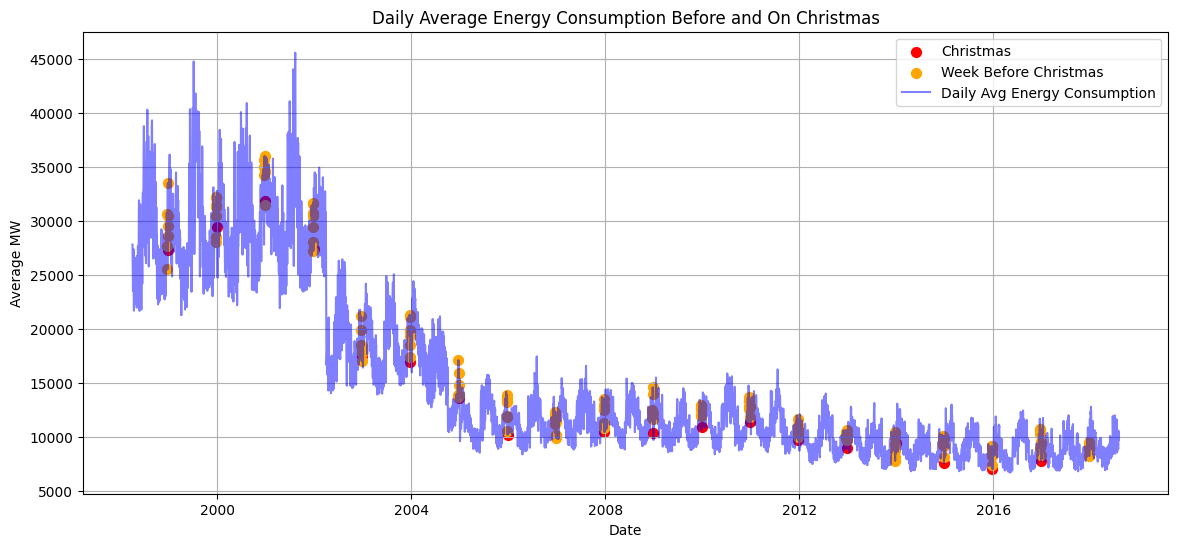

In [ ]:
#@title Visualization on average daily consumption of energy one week before Christmas and On Christmas
# aggregate data by daily mean instead of hourly
df_combined['Date'] = df_combined['Datetime'].dt.date
daily_consumption = df_combined.groupby('Date')['MW'].mean().reset_index()

# check energy consumption pattern a week before christmas and on christmas
daily_consumption['is_christmas'] = daily_consumption['Date'].apply(lambda x: is_christmas(pd.Timestamp(x)))
daily_consumption['is_week_before_christmas'] = daily_consumption['Date'].apply(
    lambda x: pd.Timestamp(x) >= pd.Timestamp(x.year, 12, 18) and pd.Timestamp(x) < pd.Timestamp(x.year, 12, 25)
)

plt.figure(figsize=(14, 6))
plt.scatter(daily_consumption[daily_consumption['is_christmas']]['Date'],
            daily_consumption[daily_consumption['is_christmas']]['MW'],
            color='red', label="Christmas", s=50)
plt.scatter(daily_consumption[daily_consumption['is_week_before_christmas']]['Date'],
            daily_consumption[daily_consumption['is_week_before_christmas']]['MW'],
            color='orange', label="Week Before Christmas", s=50)
plt.plot(daily_consumption['Date'], daily_consumption['MW'], label="Daily Avg Energy Consumption", color='blue',alpha=0.5)


plt.title("Daily Average Energy Consumption Before and On Christmas")
plt.xlabel("Date")
plt.ylabel("Average MW")
plt.legend()
plt.grid()
plt.show()


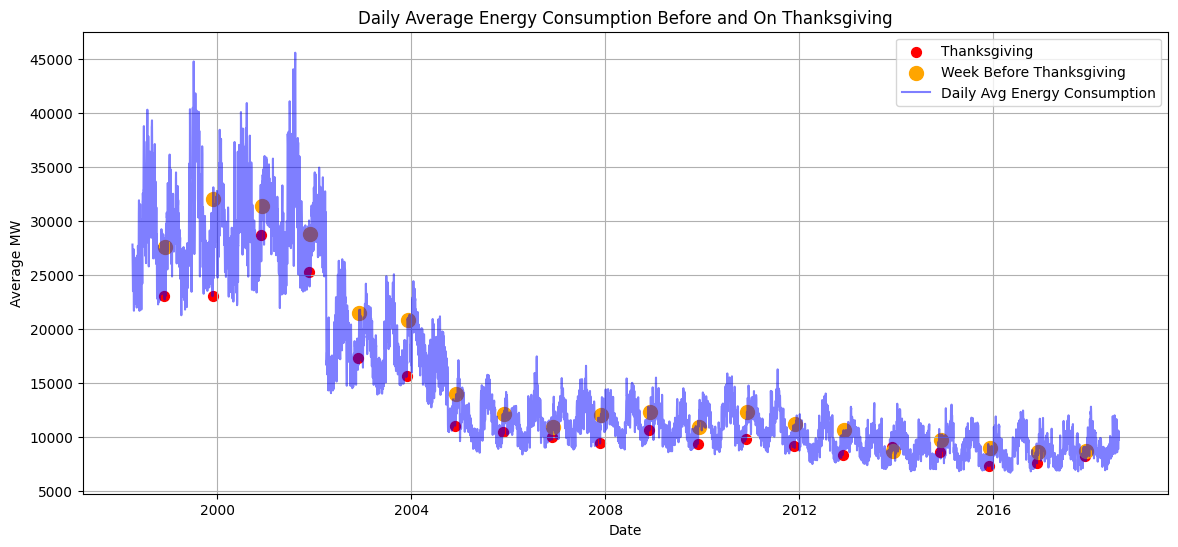

In [ ]:
#@title Visualization on daily average energy consumption one week before Thanksgiving and on Thanksgiving day
daily_consumption['is_thanksgiving'] = daily_consumption['Date'].apply(lambda x: is_thanksgiving(pd.Timestamp(x)))
daily_consumption['is_week_before_thanksgiving'] = daily_consumption['Date'].apply(
    lambda x: (pd.Timestamp(x) - pd.DateOffset(weeks=1)).date() in us_holidays and
              us_holidays.get((pd.Timestamp(x) - pd.DateOffset(weeks=1)).date()) == "Thanksgiving"
)

plt.figure(figsize=(14, 6))

plt.scatter(daily_consumption[daily_consumption['is_thanksgiving']]['Date'],
            daily_consumption[daily_consumption['is_thanksgiving']]['MW'],
            color='red', label="Thanksgiving", s=50)
plt.scatter(daily_consumption[daily_consumption['is_week_before_thanksgiving']]['Date'],
            daily_consumption[daily_consumption['is_week_before_thanksgiving']]['MW'],
            color='orange', label="Week Before Thanksgiving", s=100)

plt.plot(daily_consumption['Date'], daily_consumption['MW'], label="Daily Avg Energy Consumption", color='blue',alpha=0.5)

plt.title("Daily Average Energy Consumption Before and On Thanksgiving")
plt.xlabel("Date")
plt.ylabel("Average MW")
plt.legend()
plt.grid()
plt.show()


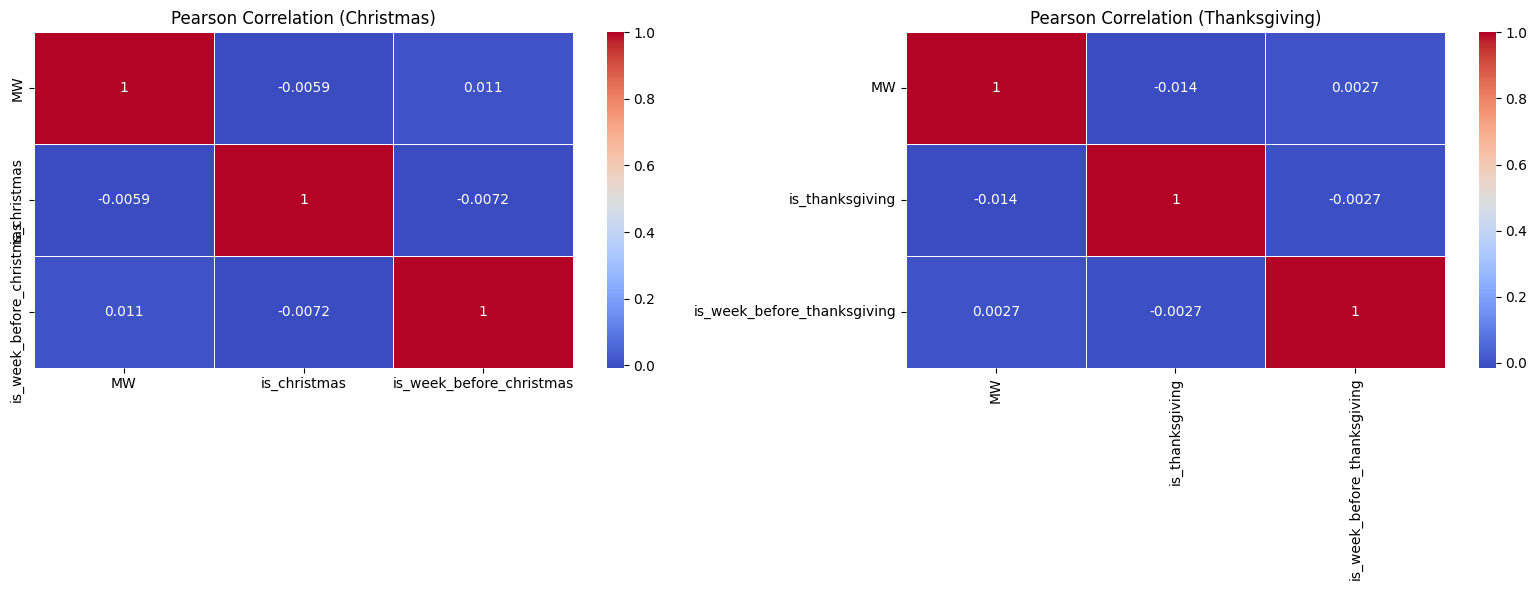

In [ ]:
christmas_data = daily_consumption[['MW', 'is_christmas', 'is_week_before_christmas']]
christmas_corr = christmas_data.corr(method='pearson')
thanksgiving_data = daily_consumption[['MW', 'is_thanksgiving', 'is_week_before_thanksgiving']]
thanksgiving_corr = thanksgiving_data.corr(method='pearson')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(christmas_corr, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[0])
axes[0].set_title("Pearson Correlation (Christmas)")

sns.heatmap(thanksgiving_corr, annot=True, cmap='coolwarm', linewidths=0.5, ax=axes[1])
axes[1].set_title("Pearson Correlation (Thanksgiving)")

plt.tight_layout()
plt.show()

### Findings on correlation between major winter holidays
The correlation between holidays and a week leading up to holidays and average energy daily consumption seem very weak, suggesting there is no linear correlation. Hypothesis 1 is False and the relevance is low.

## 1.11 Check correlation between seasons and energy consumption
By Yian
<br>
Hypothesis 2: Different seasons could have different energy consumption needs. Seasons with higher or lower temperatures require more energy use.

In [ ]:
#@title Categorize the seasons by month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    return None

daily_consumption['season'] = daily_consumption['Date'].apply(lambda x: get_season(pd.Timestamp(x)))



In [ ]:
daily_consumption.head()

,Date,MW,is_christmas,is_week_before_christmas,is_thanksgiving,is_week_before_thanksgiving,season
0,1998-04-01,27813.739130,False,False,False,False,Spring
1,1998-04-02,26605.791667,False,False,False,False,Spring
2,1998-04-03,25672.333333,False,False,False,False,Spring
3,1998-04-04,24487.083333,False,False,False,False,Spring
4,1998-04-05,23487.565217,False,False,False,False,Spring


In [ ]:
seasonal_avg = daily_consumption.groupby('season')['MW'].mean().sort_index()

print(seasonal_avg)


season
Autumn    14252.616179
Spring    13895.398957
Summer    16808.728183
Winter    15965.795960
Name: MW, dtype: float64


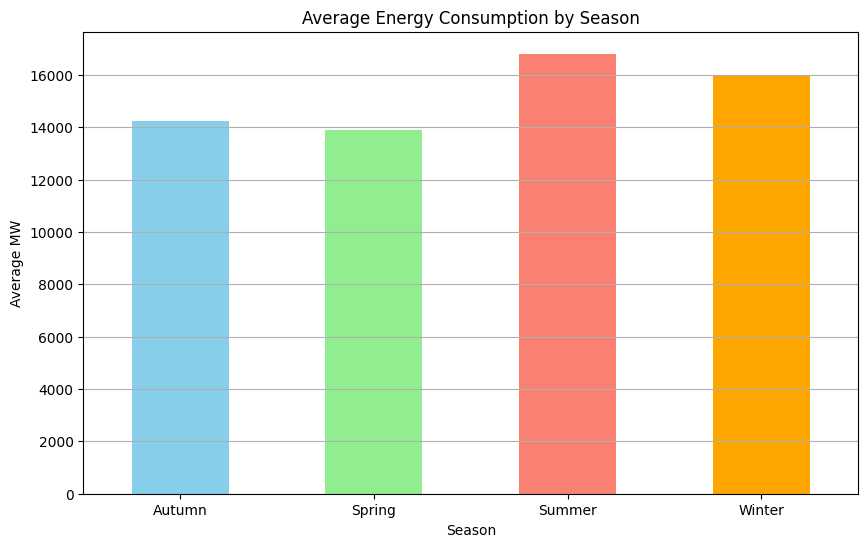

In [ ]:

plt.figure(figsize=(10, 6))
seasonal_avg.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title("Average Energy Consumption by Season")
plt.xlabel("Season")
plt.ylabel("Average MW")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


In [ ]:
daily_consumption.head()

In [ ]:
df = df_combined.copy()

In [ ]:
df['Datetime'] = pd.to_datetime( df['Datetime'] )
df['Year'] = df['Datetime'].dt.year

In [ ]:
df['season'] = df['Date'].apply(lambda x: get_season(pd.Timestamp(x)))


In [ ]:
df.head()

In [ ]:
aux2 = df[['Year', 'season', 'MW']].groupby(['Year', 'season']).sum().reset_index()

plt.figure(figsize=(14, 8))
# sns.color_palette("hls", 8)

sns.barplot(x='Year', y='MW', palette='husl',hue='season', data=aux2)
plt.title("Energy Consumption by Year and Season")
plt.xlabel("Year")
plt.ylabel("Total MW Energy Consumption")
plt.xticks(rotation=45)
plt.legend(title="Season")
plt.grid(axis='y', linestyle='--', alpha=1)
plt.show()

### Findings on different seasons having different energy consumption needs
The yearly aggregate bar chart and average bar chart show that in summer seasons the energy consumption in the US is usually highest. The second highest is normally winter or fall seasons. The pattern is consistent through the years, therefore hypothesis 2 is true.


## 1.12 Visualize how hour of the day affects energy expenditure
By Yian


In [ ]:
df['hour_of_day'] = df['Datetime'].dt.hour
aux3 = df[['hour_of_day', 'MW']].groupby( 'hour_of_day' ).sum().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot( x='hour_of_day', y='MW', data=aux3, ax=axes[0])
sns.heatmap( aux3.corr( method='pearson' ), annot=True, ax=axes[1] );

In [ ]:
df['day_of_month'] = df['Datetime'].dt.day
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month

# 2. Feature Selection and Data Preparation
By Yian


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df.columns

In [ ]:
df2 = df.copy()

In [ ]:
df2.head()

## 2.1 Synchronize the time period for the companies since the datasets start and end in different years/ date ranges

By Yian

In [ ]:
# Check the min and max dates of each datasets of different companies to see if there are overlaps
min_max = []
for i in df2['company'].unique():
    min_max.append( [ i, df2[df2['company']==i]['Date'].min(), df2[df2['company']==i]['Date'].max() ] )

mm = pd.DataFrame( columns=[ 'electric_company', 'min_date', 'max_date' ], data=min_max )
mm

 Since there are no same min and max dates for all the electrical companies, for our training data we will use all data points from earliest data (min_date) up to 1 year before last date (max_date)
 to ensure the training data captures the long history but excludes the most recent year.
 For our test set we will include the most recent data points from cut date (1 year before max_date) up to the latest date (max_date).


In [ ]:
import datetime
cut_dates = []

# get the cut dates for all companies, since all date ranges of the datasets of companies are different
for company in mm['electric_company'].unique():
    max_date = pd.to_datetime(mm[mm['electric_company'] == company]['max_date'].values[0])

    cut_date = max_date - datetime.timedelta(days=12 * 30)  # approximate 12 months as 360 days

    cut_dates.append([company, cut_date])

cutoff_df = pd.DataFrame(cut_dates, columns=['electric_company', 'cut_date'])
cutoff_df

In [ ]:
def add_company_id(X):
  """
  encodes categorical company names to numerical values
  """
  X['company_id'] = X['company'].astype('category').cat.codes

  return X

### 2.1.1 Function that synchronizes our train and test data
The training data will contain data points from the earliest data up to 1 year before last date. The test set will include the most recent data points from cut date (1 year before before the latest date).

In [ ]:
def synchronize_data(df2, cutoff_df):
  """
  synchronizes all energy consumption data of different companies to established cut-off point for train-test split
  """
  df2 = add_company_id(df2.copy())

  train_data = []
  test_data = []

  for company in cutoff_df['electric_company']:
      # cut date for each company
      cut_date = cutoff_df[cutoff_df['electric_company'] == company]['cut_date'].values[0]

      company_data = df2[df2['company'] == company]

      train = company_data[company_data['Datetime'] < cut_date]
      test = company_data[company_data['Datetime'] >= cut_date]

      train_data.append(train)
      test_data.append(test)

  train_df = pd.concat(train_data)
  test_df = pd.concat(test_data)
  return train_df, test_df

## 2.2 Creating Data Pipeline and Applying Feature Transformation
By Yian
<br>
<br>
### 2.2.1 Encoding Cyclical Features

<br>
A common method to encode cyclical data is to transform data into two dimensions using sine and cosine transformation.
We want to transform the original features into cyclical features (hour of day, day of week, day of month, season) to capture the cyclical nature of these variables. Since we're working with time series data, features like hour of the day, day of the week, and seasons etc. have a cyclical pattern. By applying sine and cosine transformations we project these values onto a circle for our models to learn the cyclical natures. Sine captures the y-axis information and cosine captures the x-axis information.
<br>
We perform the following transformations:
\begin{align*}
x_{\sin} &= \sin\left(\frac{2 \cdot \pi \cdot x}{\max(x)}\right) \\
x_{\cos} &= \cos\left(\frac{2 \cdot \pi \cdot x}{\max(x)}\right)
\end{align*}
<br>
<br>

### 2.2.2 Building Preprocessing Pipeline
For our data pipeline, we apply feature transformations such as encoding features to cyclical patterns using sine and cosine. We also encode the seasons and holiday features.
<br>
No further normalization is needed for this data since transforming the data to cyclical features (with sine and cosine) already normalizes them between -1 and 1.


In [ ]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass

    def fit(self, X, y=None):
        return self

    def encode_seasons_holidays (self, X):
      """
      encodes seasons and holiday values
      """
      # Mapping the seasons categorical variable to ordinal values because there is ordinal relationship
      ordinal_encode_season = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
      X['season'] = X['season'].map(ordinal_encode_season)

      # One-hot encode holidays (change to binary values)
      X['is_holiday'] = X['is_holiday'].astype(int)

      return X

    def transform(self, X):
      """
      returns X with encoded features
      """

      X = self.encode_seasons_holidays(X.copy())

      # Sine-cosine transformation for cyclical features
      # hour of day range from 0 to 23, so this scales our hour of the day to fit in circle 0 to 2pi radians
      X['hour_of_day_sin'] = X['hour_of_day'].apply(lambda x: np.sin(x * (2. * np.pi / 24.)))
      X['hour_of_day_cos'] = X['hour_of_day'].apply(lambda x: np.cos(x * (2. * np.pi / 24.)))

      # split seasons to 4 parts
      X['season_sin'] = X['season'].apply(lambda x: np.sin(x * (2. * np.pi / 4.)))
      X['season_cos'] = X['season'].apply(lambda x: np.cos(x * (2. * np.pi / 4.)))

      X['day_of_week_sin'] = np.sin(X['day_of_week'] * (2. * np.pi / 7.))
      X['day_of_week_cos'] = np.cos(X['day_of_week'] * (2. * np.pi / 7.))

      X['day_of_month_sin'] = np.sin(X['day_of_month'] * (2. * np.pi / 31.))
      X['day_of_month_cos'] = np.cos(X['day_of_month'] * (2. * np.pi / 31.))

      # Drop unwanted columns
      cols_drop = ['hour_of_day','is_thanksgiving','is_christmas','is_week_before_christmas','is_week_before_thanksgiving', 'season', 'day_of_week', 'day_of_month']
      X = X.drop(columns=cols_drop, errors='ignore')

      return X


# 3. Split dataframe to train and test dataset
By Yian



In [ ]:
features = [
    'hour_of_day_sin', 'hour_of_day_cos',
    'season_sin', 'season_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'day_of_month_sin', 'day_of_month_cos',
    'company_id'
]

target = 'MW'

preprocessor = CustomPreprocessor()
df_transformed = preprocessor.transform(df2)
train_df, test_df = synchronize_data(df_transformed, cutoff_df)

# get select features
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


In [ ]:
X_train.head()

# 4. Random Forest Model
By Yian


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


initial_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
initial_rf_model.fit(X_train, y_train)


In [ ]:
#@title Predict Training Data
y_train_pred = initial_rf_model.predict(X_train)

y_test_pred = initial_rf_model.predict(X_test)


## 4.1 Model Evaluation with R-Squared and RMSE
By Yian
<br>
We evaluate with R-squared $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$, where y_i is the target value and y_hat is the predicted value, to check how well the model fits the data (1.0 is perfect fit). We also use Root Mean Sqaured Error (RMSE) $\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$
to measure the standard deviation of residuals (predition errors). The lower the RMSE means less error, which indicates better fit.

In [ ]:
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")


## 4.2 Check Feature Importance of the Random Forest Model
Yian

In [ ]:
import matplotlib.pyplot as plt

feature_importance = initial_rf_model.feature_importances_

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importance in Random Forest Regressor")
plt.show()


The high feature importance of 'company_id' in the Random Forest model is likely because the company_id acts as a unique categorical identifier of the source of the data. Since different electric companies in the dataset have unique patterns of energy consumption due to geographical, environmental, and operational differences. These companies are in different regions and have distinct seasonal behaviors and energy demands. As a result, the 'company_id' could help the model easily differentiate and make better predictions based on the company.


## 4.3 Create Feature Selector Transformer
By Yian
<br>
Build top k feature selector based on Random Forest base model feature importance to add to our data pipeline

In [ ]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k

    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self

    def transform(self, X):
        return X.iloc[:, self.feature_indices_]


## 4.4 Putting together the data pipeline for feature selector and running RF model after feature selection on initial model
By Yian

In [ ]:
# pipeline after adding feature selector

top_k_features = 5

data_pipeline = Pipeline([
    ('feature_selector', TopFeatureSelector(feature_importance, top_k_features)),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

data_pipeline.fit(X_train, y_train)

# predictions
y_train_pred = data_pipeline.predict(X_train)
y_test_pred = data_pipeline.predict(X_test)

## 4.5 Evaluation on RF Model after top 5 feature selection
By Yian

In [ ]:
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Training R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

## Conclusion on Random Forest Model
By Yian

The Random Forest initial model achieves a fairly high score with an RMSE of 1987.45 on the test set and 0.962 for the R^2. The Random Forest model after feature selections indicates even more robust performance of 1752.68 on the test set (lower prediction error) and R^2 score of 0.97, which demonstrates that the selecting only the top k important features helps reduce the feature space (dimensionality of data) and model complexity, which in turn helps the model generalize even better.

# 5 .RNN Model

By Hogan

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [ ]:
#Plotting hourly energy usage:
AEP = pd.read_csv(os.path.join(path, "AEP_hourly.csv"), index_col=[0], parse_dates=[0])

mau = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
bieudo = AEP.plot(style='.',figsize=(15,5), color=mau[0], title='AEP')

#Data transformation
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(AEP, label='AEP_MW')
features_and_target = pd.concat([X, y], axis=1)
print(features_and_target)
plt.show()

plt.figure(figsize=(15,6))
data_csv = AEP.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
plt.plot(dataset)
print(max_value, min_value)

In [ ]:
#choosing DOM_hourly.csv data for analysis
fpath='./dataset/DOM_hourly.csv'

#Let's use datetime(2012-10-01 12:00:00,...) as index instead of numbers(0,1,...)
#This will be helpful for further data analysis as we are dealing with time series data
df = pd.read_csv(os.path.join(path, "DOM_hourly.csv"), index_col='Datetime', parse_dates=['Datetime'])
df.head()

#checking missing data
df.isna().sum()

#Data visualization

df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [ ]:
#Normalize DOM hourly power consumption data

def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

#Visualize data after normalization

df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [ ]:
# train data for deep learning models

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len: i, 0])
        y_train.append(stock.iloc[i, 0])

    # 1 last 6189 days are going to be used in test
    X_test = X_train[110000:]
    y_test = y_train[110000:]

    # 2 first 110000 days are going to be used in training
    X_train = X_train[:110000]
    y_train = y_train[:110000]

    # 3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # 4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [ ]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

By Pranay
We want to compare different models using the performance metrics , here we are using a Simple RNN as a base to start with, The performance metrics we used is R2 score and by adjusting the number of layers and the dropout rate we want to increase the performance.

In [ ]:
#RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.25))
rnn_model.add(Dense(1))
rnn_model.summary()
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

In [ ]:
#r2 score for the values predicted by the above trained SIMPLE RNN model

rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

In [ ]:
# compare the actual values vs predicted values by plotting a graph

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [ ]:
#train model for LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

In [ ]:
#r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

In [ ]:
#actual values vs predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [ ]:
#RNN, LSTM model by plotting data in a single graph
plt.figure(figsize=(15,8))
plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()